# Homework 4

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

C:\Users\Avshugan\AppData\Local\Temp\ipykernel_7876\2344506368.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображенииа, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершут предобработку картинки, писанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер равномерно занимало место, то есть если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в приложении к этому занятию.

<table><tr>
    <td> <img src="https://i.ibb.co/fkScTsg/test_image_01.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/q7PQRtZ/test_image_03.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/StTqhST/test_image_08.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

## Алгоритм описан в функции contours

In [2]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6*2, 4*2), constrained_layout=True)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

In [3]:
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=True)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Результат преобразования')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

In [4]:
def del_cont(image, size=100, ysize = 30):
    im = image.copy()
    im = np.pad(im, 1)
    im =np.uint8((im == 0)*255)
    
    h, w = im.shape
    ny = h//size+1
    nx = w//size+1
    laddy = [0, size//4, size//2, size*3//4]
    laddx = [0, size//4, size//2, size*3//4]
    for addy in laddy:
        for addx in laddx:
            for i in range(ny):
                for j in range(nx):
                    slicei = im[i*size+addy:(i+1)*size+1+addy, j*size+addx:(j+1)*size+1+addx]
                    contours, hierarchy = cv2.findContours(slicei.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                    temp = cv2.drawContours(slicei, contours, -1, 255, cv2.FILLED)
                    im[i*size+addy:(i+1)*size+1+addy, j*size+addx:(j+1)*size+1+addx] = temp
    
    if ysize != -1:
        laddy = [0, ysize//2]
        ny = h//ysize+1
        for addy in laddy:
                for i in range(ny):
                        slicei = im[i*size+addy:(i+1)*size+1+addy, :]
                        contours, hierarchy = cv2.findContours(slicei.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                        temp = cv2.drawContours(slicei, contours, -1, 255, cv2.FILLED)
                        im[i*size+addy:(i+1)*size+1+addy, :] = temp
        
        
    im = np.delete(im, w-1, 1)
    im = np.delete(im, h-1, 0)
    im = np.delete(im, 0, 1)
    im = np.delete(im, 0, 0)
    return im

In [5]:
def get_color_area(mask, y0, x0, color):
    """
    Выделяет область цвета col ограниченую другим цветом
    """
    col = np.uint8((color == 0)*255)
    h, w = mask.shape
    temp_mask = mask.copy()
    area = [[y0,x0]]
    queue = [[y0,x0]]
    temp_mask[y0][x0] = col
    area_on_edge = False
    num = 0
    while num < len(area):
        y, x = area[num]
        
        mini = -1
        minj = -1
        maxi = 2
        maxj = 2
        if y == 0:
            area_on_edge = True 
            mini = 0
        if x == 0:
            area_on_edge = True 
            minj = 0  
        if y == h-1:
            area_on_edge = True
            maxi = 1
        if x == w-1:
            area_on_edge = True
            maxj = 1
            
        for i in range(mini,maxi):
            for j in range(minj,maxj):
                if temp_mask[y+i][x+j] != col:
                    temp_mask[y+i][x+j] = col
                    area.append([y+i,x+j])
        num += 1
    return area, area_on_edge

In [6]:
def del_white(mask):
    """
    Закрашивает черным белые области не соприкасающиеся с границей
    """
    h, w = mask.shape
    temp_mask = mask.copy()
    new_mask = mask.copy()
    for y in range(h):
        for x in range(w):
            if temp_mask[y][x] != 0:
                area, area_on_edge = get_color_area(temp_mask, y, x, 255)
                for yi,xi in area:
                    temp_mask[yi][xi] = 0
                
                if not area_on_edge and len(area) > 1:
                    xi = [p[0] for p in area]
                    yi = [p[1] for p in area]
                    s = len(area)
                    d = max( max(xi)-min(xi), max(yi)-min(yi) )
                    if s/d > 20:
                        for yj,xj in area:
                            new_mask[yj][xj] = 0
    return new_mask              

In [7]:
def get_another_col_distance(mask, y0, x0):
    """
    Сумма расстояний до другого цвета по x и по y, 
    также возвращает дошел ли он до граници в поиске этих расстояний 
    """
    h, w = mask.shape
    col = mask[y0][x0]
    edgex = False
    edgey = False
    
    dx = 0
    y,x = y0, x0
    while x < w-1 and mask[y][x] == col:
        dx += 1
        x += 1
    if x == w-1:
        edgex = True
        
    y,x = y0, x0
    while x > 0 and mask[y][x] == col:
        dx += 1
        x -= 1
    if x == 0:
        edgex = True
    
    dy = 0
    y,x = y0, x0
    while y < h-1 and mask[y][x] == col:
        dy += 1
        y += 1
    if y == h-1:
        edgey = True
        
    y,x = y0, x0
    while y > 0 and mask[y][x] == col:
        dy += 1
        y -= 1
    if y == 0:
        edgey = True
        
    return dy, dx, edgex, edgey

In [8]:
def get_max_black_area(mask):
    """
    Выделяет 1 или 2 самые большие области черного (возвращает 2, если у нас есть 2 большие области)
    Возвращает маску этих областей (ну или области)
    """
    h, w = mask.shape
    temp_mask = mask.copy()
    max_area = []
    max2_area = []
    
    for y in range(h):
        for x in range(w):
            if temp_mask[y][x] != 255:
                dy, dx, _, _ = get_another_col_distance(mask, y, x)
                if dy < 5 or dx < 5:
                    temp_mask[y][x] = 255
    
    for y in range(h):
        for x in range(w):
            if temp_mask[y][x] != 255:
                area, area_on_edge = get_color_area(temp_mask, y, x, 0)
                for yi,xi in area:
                    temp_mask[yi][xi] = 255
                
                if len(area) > len(max_area):
                    max2_area = max_area.copy()
                    max_area = area.copy() 
                elif len(area) > len(max2_area):
                    max2_area = area.copy() 
    
    new_mask = np.zeros(mask.shape)
    for y, x in max_area:
        new_mask[y][x] = 255
        
    if len(max_area) < len(max2_area)*2:
        for y, x in max2_area:
            new_mask[y][x] = 255
        
    return new_mask

In [9]:
def clear_mask(mask):
    """
    Убирает белые области в нутри нашей черной области хвоста
    """
    h, w = mask.shape
    temp_mask = mask.copy()
    max_area = []
    max2_area = []
    
    for y in range(h):
        for x in range(w):
            if temp_mask[y][x] == 0:
                dy, dx, edgex, edgey = get_another_col_distance(mask, y, x)
                if (not edgex and dx < 40) or (not edgey and dy < 40):
                    temp_mask[y][x] = 255
    return temp_mask

In [52]:
def get_M_perspective(mask):
    """
    Ищем матрицу преобразования
    """
    H, W = mask.shape
    temp_mask = np.uint8((mask == 0)*255)
    
    thresh = cv2.threshold(temp_mask[:,:W//2], 220, 255, cv2.THRESH_BINARY_INV)[1]
    x, y, w, h = cv2.boundingRect(thresh)                                                
    left = x            
    top1 = y
    
    thresh = cv2.threshold(temp_mask[:,W//2:], 220, 255, cv2.THRESH_BINARY_INV)[1]
    x, y, w, h = cv2.boundingRect(thresh)                                               
    right = W//2+x+w-1            
    top2 =  y
    
    
    thresh = cv2.threshold(temp_mask, 220, 255, cv2.THRESH_BINARY_INV)[1]
    x, y, w, h = cv2.boundingRect(thresh) 
    bottom = y+h-1
    
    new_W = right-left
    new_H = bottom-min(top2, top1)
    pts1 = np.float32([[left, top1], [right, top2], [(right+left)//2, bottom]])
    pts2 = np.float32([[0, 0], [new_W-1, 0], [new_W//2, new_H-1]])
    
    M = cv2.getAffineTransform(pts1, pts2)
    return M, new_W, new_H   

In [53]:
# def get_perspective(mask):
#     plot_one_image(mask, is_gray=True)
#     H, W = mask.shape
# #     temp_mask = mask.copy().astype(np.uint8)
#     temp_mask = np.uint8((mask == 0)*255)
#     thresh = cv2.threshold(temp_mask, 220, 255, cv2.THRESH_BINARY_INV)[1]

#     cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cnts = cnts[0] if len(cnts) == 2 else cnts[1]
#     c = max(cnts, key=cv2.contourArea)

#     left = tuple(c[c[:, :, 0].argmin()][0])
#     right = tuple(c[c[:, :, 0].argmax()][0])
#     top = tuple(c[c[:, :, 1].argmin()][0])
#     bottom = tuple(c[c[:, :, 1].argmax()][0])
    
    
#     nW = right[0]-left[0]
#     nH = bottom[1]-top[1]
#     point1 = np.float32([[left[0], top[1]], [right[0], top[1]], [(right[0]+left[0])//2, bottom[1]]])
#     point2 = np.float32([[0, 0], [nW-1, 0], [nW//2, nH-1]])
    
#     M = cv2.getAffineTransform(point1, point2)
#     return M, nW, nH

In [54]:
def contours(image, scale=0.55, ksize=5, kersize=5):
    """
    Функция, которая собственно все и делает 
    """
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # выделяем границы
    gray_img = cv2.GaussianBlur(gray_img, ksize=(9, 9), sigmaX=1, sigmaY=1)
    
    laplac = cv2.Laplacian(gray_img, cv2.THRESH_BINARY, scale=scale, ksize=ksize)
    laplac = np.uint8((laplac != 0)*255)
    # конец выделения границ
    
    # чистим лишние контуры (как можем)
    laplac = del_cont(laplac)
    laplac = del_cont(laplac, 70, -1)
    laplac = np.uint8((laplac == 0)*255)
    # конец чистки
    
    # удаляем большие куски белого (пытаемся заполнить контур хвоста)
    laplac = del_white(laplac)
    
    # теперь ищем собственно хвост 
    mask = get_max_black_area(laplac)
    
    # добавляем точки, которые внутри хвоста, но мы их не взяли
    mask = clear_mask(mask)
    
    # применяем маску
    tail_mask = np.zeros_like(image)
    tail_mask[:,:,0] = np.uint8(mask == 255)
    tail_mask[:,:,1] = np.uint8(mask == 255)
    tail_mask[:,:,2] = np.uint8(mask == 255)
    tail_im = image*tail_mask
    tail_im = cv2.cvtColor(tail_im, cv2.COLOR_RGB2BGR)
    # конец 
    
    # ищем преобразование и применяем его
    M, new_W, new_H = get_M_perspective(mask)
#     M, new_W, new_H = get_perspective(mask)
    res = cv2.warpAffine(tail_im.copy(), M, (new_W, new_H))
    
    # вуаля
    plot_one_image(res, is_gray=True)
    return res

In [55]:
def go(image):
    """
    Функия запуска
    """
    h, w, _ = image.shape
    image = cv2.resize(image.copy(), (w // 2, h // 2))
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    print(h, w)
    contours(image, 0.005, 9, 7)

In [56]:
def go_i(num=-1):
    """
    Функция для удобного запуска тестов
    num - номер картинки (из названия файла)
    если num == -1, выводит все картинки
    """
    if num == -1:
        for i in range(0, 10):
            if i == 4 or i == 5:
                continue
            print(f"image {i}")
            image = cv2.imread(f'whale_tail/test_image_0{i}.jpg')
            go(image)
            print("----------------")
        for i in range(10, 13):
            print(f"image {i}")
            image = cv2.imread(f'whale_tail/test_image_{i}.jpg')
            go(image)
            print("----------------")
    else:
        print(f"image {num}")
        if num < 10:
            image = cv2.imread(f'whale_tail/test_image_0{num}.jpg')
        else:
            image = cv2.imread(f'whale_tail/test_image_{num}.jpg')
        go(image)

image 1
417 1050


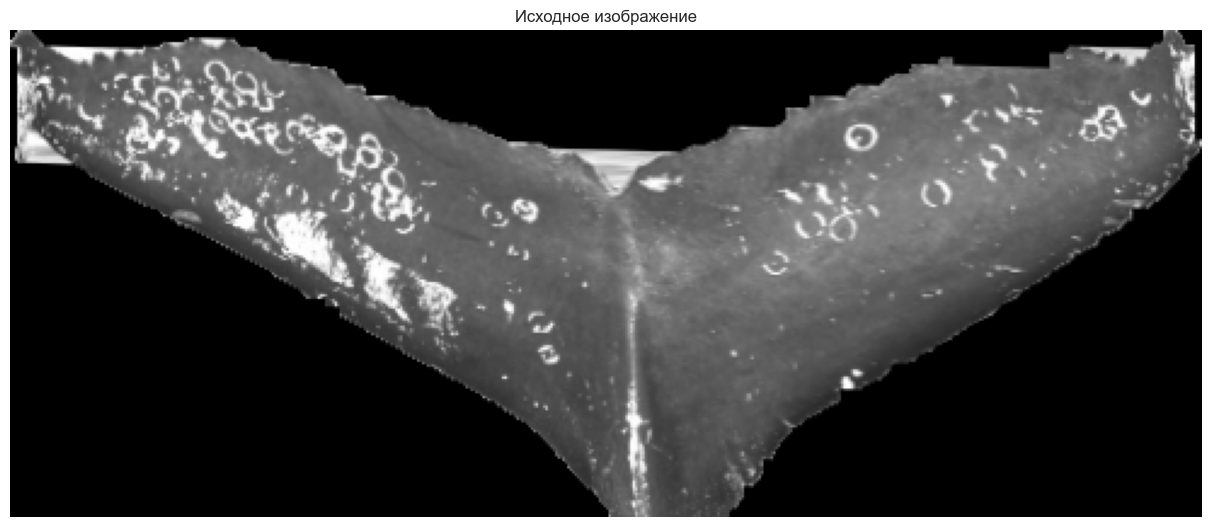

image 8
667 1000


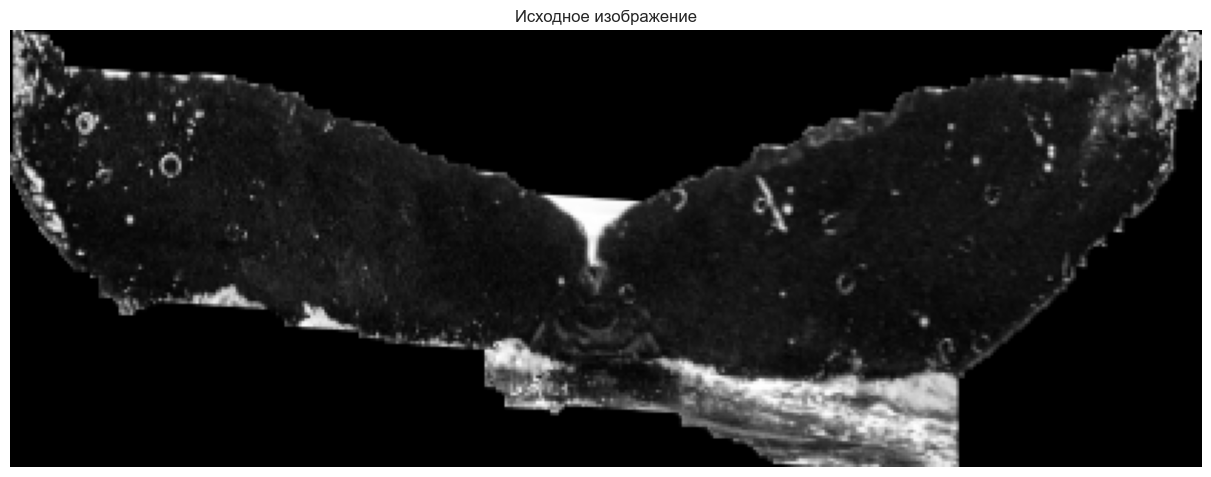

In [57]:
# go_i(0)
go_i(1)
go_i(8)
# go_i(10)